# Heart Disease Risk Prediction: Logistic Regression

**Course:** AREP - Machine Learning Bootcamp

**Objective:** Implement logistic regression from scratch to predict heart disease risk.

**Dataset:** Heart_Disease_Prediction.csv from Kaggle (270 patients, 14 features)

**Constraints:** NumPy, Pandas, Matplotlib only. No scikit-learn for core training.

In [ ]:
# Install required packages 
%pip install numpy pandas matplotlib

  Using cached numpy-2.4.1-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.1.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
Using cached numpy-2.4.1-cp313-cp313-win_amd64.whl (12.3 MB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.7 MB 11.3 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/9.7 MB 11.3 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/9.7 MB 11.3 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/9.7 MB 11.3 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=4, suppress=True)
np.random.seed(42)  # so i can have the same results later

---
# Step 1: Load and Prepare the Dataset

## 1.1 Load the Data

Dataset downloaded from: https://www.kaggle.com/datasets/neurocipher/heartdisease

In [ ]:
df = pd.read_csv('Heart_Disease_Prediction.csv')

print(f"Loaded: Heart_Disease_Prediction.csv")
print(f"\nDataset shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Loaded: Heart_Disease_Prediction.csv

Dataset shape: (270, 14)
Rows: 270, Columns: 14


In [ ]:
print("First 5 rows:")
df.head()

First 5 rows:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [ ]:
print("Column Information:")
print(df.dtypes)
print("\nColumn names:")
print(df.columns.tolist())

Column Information:
Age                          int64
Sex                          int64
Chest pain type              int64
BP                           int64
Cholesterol                  int64
FBS over 120                 int64
EKG results                  int64
Max HR                       int64
Exercise angina              int64
ST depression              float64
Slope of ST                  int64
Number of vessels fluro      int64
Thallium                     int64
Heart Disease                  str
dtype: object

Column names:
['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease']


## 1.2 Exploratory Data Analysis (EDA)

### Summary Statistics

In [ ]:
print("Statistical Summary:")
df.describe()

Statistical Summary:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


In [ ]:
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values in the set")
print(f"\nTotal missing: {df.isnull().sum().sum()}")

Missing Values:
No missing values found!

Total missing: 0


In [ ]:
target_col = 'Heart Disease'

print(f"Target column: '{target_col}'")
print(f"\nTarget value counts:")
print(df[target_col].value_counts())

Target column: 'Heart Disease'

Target value counts:
Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64


### Binarize Target Variable

Ensure target is binary: 1 = disease presence, 0 = absence

In [ ]:
print(f"Unique values in target: {df[target_col].unique()}")

# Binarize: 'Presence' = 1, 'Absence' = 0
df['target_binary'] = df[target_col].apply(lambda x: 1 if x == 'Presence' else 0)

print(f"\nBinarized target distribution:")
print(df['target_binary'].value_counts())
print(f"\nDisease rate: {df['target_binary'].mean()*100:.1f}%")

Unique values in target: <StringArray>
['Presence', 'Absence']
Length: 2, dtype: str

Binarized target distribution:
target_binary
0    150
1    120
Name: count, dtype: int64

Disease rate: 44.4%


### Class Distribution Visualization

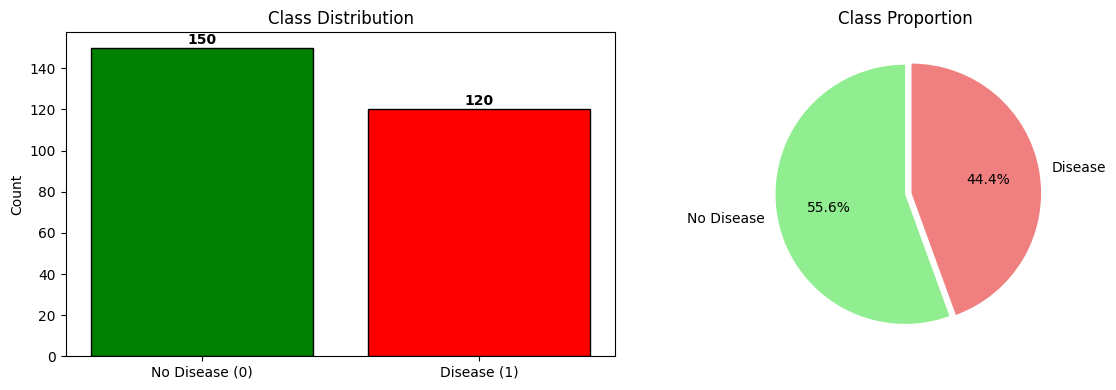

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
class_counts = df['target_binary'].value_counts()
axes[0].bar(['No Disease (0)', 'Disease (1)'], class_counts.values, 
            color=['green', 'red'], edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 2, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=['No Disease', 'Disease'], 
            autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'],
            explode=(0, 0.05), startangle=90)
axes[1].set_title('Class Proportion')

plt.tight_layout()
plt.show()

### Feature Analysis

In [ ]:
# Now we see which are features (exclude target), so they must be numeric
exclude_cols = [target_col, 'target_binary']
feature_cols = [col for col in df.columns if col not in exclude_cols]
numerical_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Available features ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Available features (13):
  1. Age
  2. Sex
  3. Chest pain type
  4. BP
  5. Cholesterol
  6. FBS over 120
  7. EKG results
  8. Max HR
  9. Exercise angina
  10. ST depression
  11. Slope of ST
  12. Number of vessels fluro
  13. Thallium


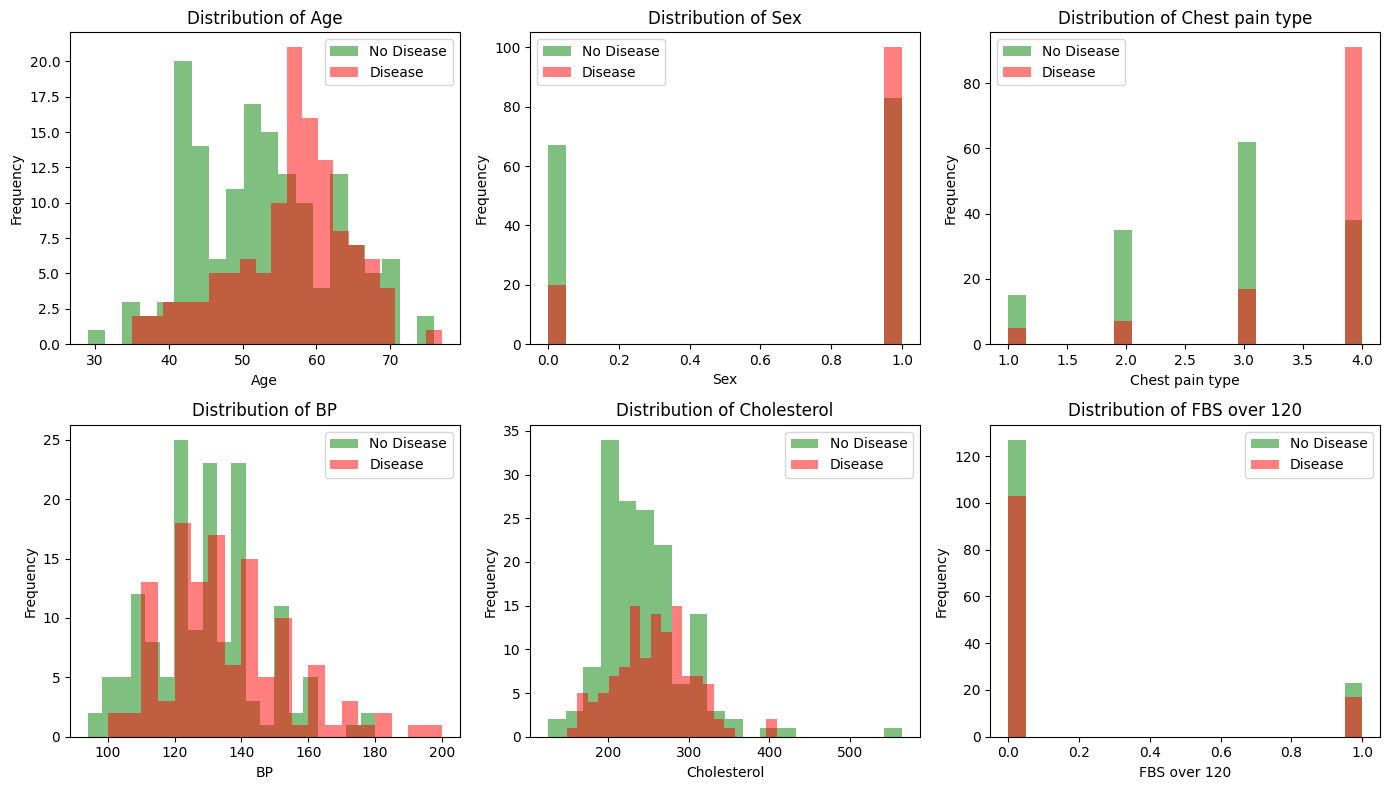

In [ ]:
# Distribution of key numerical features
key_features = numerical_cols[:6] if len(numerical_cols) >= 6 else numerical_cols

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, col in enumerate(key_features):
    if idx < len(axes):
        # Histograma
        for label, color in [(0, 'green'), (1, 'red')]:
            subset = df[df['target_binary'] == label][col]
            axes[idx].hist(subset, bins=20, alpha=0.5, color=color, 
                          label=f"{'Disease' if label else 'No Disease'}")
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].set_title(f'Distribution of {col}')

# Hide unused subplots
for idx in range(len(key_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Handle Outliers (if any)

In [ ]:
# Check for outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return len(outliers), lower, upper

print("Outlier Analysis (IQR method):")
print("-" * 50)
for col in numerical_cols[:8]:
    count, lower, upper = detect_outliers_iqr(df, col)
    if count > 0:
        print(f"{col}: {count} outliers (range: {lower:.1f} - {upper:.1f})")

print("\nNote: Outliers are kept as they may represent genuine clinical variations.")

## 1.3 Feature Selection

Select at least 6 features for the model.

In [ ]:
# Select features for the model (using actual column names from dataset)
selected_features = [
    'Age',
    'Sex', 
    'Chest pain type',
    'BP',
    'Cholesterol',
    'FBS over 120',
    'EKG results',
    'Max HR',
    'Exercise angina',
    'ST depression'
]

print(f"Selected {len(selected_features)} features for the model:")
for i, f in enumerate(selected_features, 1):
    print(f"  {i}. {f}")

## 1.4 Train/Test Split (70/30 Stratified)

In [ ]:
def stratified_split(X, y, test_size=0.3, random_state=42):
    """
    Perform stratified train/test split without sklearn.
    Maintains class proportions in both sets.
    """
    np.random.seed(random_state)
    
    # Get indices for each class
    idx_class_0 = np.where(y == 0)[0]
    idx_class_1 = np.where(y == 1)[0]
    
    # Shuffle indices
    np.random.shuffle(idx_class_0)
    np.random.shuffle(idx_class_1)
    
    # Calculate split sizes
    n_test_0 = int(len(idx_class_0) * test_size)
    n_test_1 = int(len(idx_class_1) * test_size)
    
    # Split each class
    test_idx = np.concatenate([idx_class_0[:n_test_0], idx_class_1[:n_test_1]])
    train_idx = np.concatenate([idx_class_0[n_test_0:], idx_class_1[n_test_1:]])
    
    # Shuffle final indices
    np.random.shuffle(test_idx)
    np.random.shuffle(train_idx)
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Prepare data
X = df[selected_features].values
y = df['target_binary'].values

# Split
X_train, X_test, y_train, y_test = stratified_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(f"  Class 0: {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"  Class 0: {np.sum(y_test == 0)} ({np.mean(y_test == 0)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_test == 1)} ({np.mean(y_test == 1)*100:.1f}%)")

## 1.5 Feature Normalization (Standardization)

In [ ]:
def normalize_features(X_train, X_test):
    """
    Standardize features using training set statistics.
    z = (x - mean) / std
    """
    # Compute mean and std from training set only
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    # Avoid division by zero
    std[std == 0] = 1
    
    # Normalize both sets using training statistics
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_test_norm, mean, std

# Normalize
X_train_norm, X_test_norm, feature_mean, feature_std = normalize_features(X_train, X_test)

print("Feature Statistics (Training Set):")
print("-" * 60)
print(f"{'Feature':<20} {'Mean':>10} {'Std':>10} {'Norm Mean':>12} {'Norm Std':>10}")
print("-" * 60)
for i, feat in enumerate(selected_features):
    print(f"{feat:<20} {feature_mean[i]:>10.2f} {feature_std[i]:>10.2f} "
          f"{X_train_norm[:, i].mean():>12.4f} {X_train_norm[:, i].std():>10.4f}")

## 1.6 Data Preparation Summary

In [ ]:
print("="*70)
print("DATA PREPARATION SUMMARY")
print("="*70)
print(f"\nDataset: Heart Disease from Kaggle")
print(f"Source: https://www.kaggle.com/datasets/neurocipher/heartdisease")
print(f"\nTotal samples: {len(df)}")
print(f"Disease presence rate: {df['target_binary'].mean()*100:.1f}%")
print(f"\nFeatures selected ({len(selected_features)}): {selected_features}")
print(f"\nTrain/Test split: 70/30 (stratified)")
print(f"  - Training: {len(X_train)} samples")
print(f"  - Test: {len(X_test)} samples")
print(f"\nPreprocessing: Standardization (z-score normalization)")
print(f"Missing values: {df.isnull().sum().sum()}")
print("="*70)

---
# Step 2: Implement Basic Logistic Regression

## 2.1 Mathematical Foundation

### Sigmoid Function
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

### Hypothesis
$$h_\theta(x) = \sigma(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}$$

### Binary Cross-Entropy Cost Function
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h_\theta(x^{(i)})) + (1-y^{(i)}) \log(1-h_\theta(x^{(i)})) \right]$$

### Gradient
$$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}$$

## 2.2 Core Functions Implementation

In [ ]:
def sigmoid(z):
    """
    Compute sigmoid function.
    Clips input to avoid overflow.
    
    Parameters:
    -----------
    z : array-like
        Input values
    
    Returns:
    --------
    array-like
        Sigmoid of z, values in range (0, 1)
    """
    # Clip to prevent overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

# Test sigmoid
test_z = np.array([-10, -1, 0, 1, 10])
print("Sigmoid function test:")
print(f"z = {test_z}")
print(f"sigmoid(z) = {sigmoid(test_z)}")
print(f"\nNote: sigmoid(0) = 0.5 (as expected)")

In [ ]:
# Visualize sigmoid
z_range = np.linspace(-10, 10, 100)
plt.figure(figsize=(8, 5))
plt.plot(z_range, sigmoid(z_range), 'b-', linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Threshold (0.5)')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('z')
plt.ylabel('sigmoid(z)')
plt.title('Sigmoid Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def compute_cost(X, y, w, b):
    """
    Compute binary cross-entropy cost function.
    
    Parameters:
    -----------
    X : ndarray (m, n)
        Training examples
    y : ndarray (m,)
        Target labels (0 or 1)
    w : ndarray (n,)
        Weight parameters
    b : float
        Bias parameter
    
    Returns:
    --------
    float
        Cost value
    """
    m = X.shape[0]
    
    # Compute predictions
    z = X @ w + b
    h = sigmoid(z)
    
    # Clip to avoid log(0)
    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    
    # Binary cross-entropy
    cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    
    return cost

# Test cost function
n_features = X_train_norm.shape[1]
w_test = np.zeros(n_features)
b_test = 0.0
initial_cost = compute_cost(X_train_norm, y_train, w_test, b_test)
print(f"Initial cost (w=0, b=0): {initial_cost:.4f}")
print(f"Expected initial cost for balanced data: ~{np.log(2):.4f} (log(2))")

In [ ]:
def compute_gradients(X, y, w, b):
    """
    Compute gradients for logistic regression.
    
    Parameters:
    -----------
    X : ndarray (m, n)
        Training examples
    y : ndarray (m,)
        Target labels
    w : ndarray (n,)
        Weight parameters
    b : float
        Bias parameter
    
    Returns:
    --------
    dw : ndarray (n,)
        Gradient of cost w.r.t. w
    db : float
        Gradient of cost w.r.t. b
    """
    m = X.shape[0]
    
    # Compute predictions
    z = X @ w + b
    h = sigmoid(z)
    
    # Compute error
    error = h - y
    
    # Compute gradients
    dw = (1/m) * (X.T @ error)
    db = (1/m) * np.sum(error)
    
    return dw, db

# Test gradients
dw, db = compute_gradients(X_train_norm, y_train, w_test, b_test)
print(f"Initial gradients:")
print(f"dw = {dw}")
print(f"db = {db:.4f}")

## 2.3 Gradient Descent Implementation

In [ ]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iterations, verbose=True):
    """
    Perform gradient descent for logistic regression.
    
    Parameters:
    -----------
    X : ndarray (m, n)
        Training examples
    y : ndarray (m,)
        Target labels
    w_init : ndarray (n,)
        Initial weights
    b_init : float
        Initial bias
    alpha : float
        Learning rate
    num_iterations : int
        Number of iterations
    verbose : bool
        Print progress
    
    Returns:
    --------
    w : ndarray (n,)
        Learned weights
    b : float
        Learned bias
    cost_history : list
        Cost at each iteration
    """
    w = w_init.copy()
    b = b_init
    cost_history = []
    
    for i in range(num_iterations):
        # Compute gradients
        dw, db = compute_gradients(X, y, w, b)
        
        # Update parameters
        w = w - alpha * dw
        b = b - alpha * db
        
        # Track cost
        cost = compute_cost(X, y, w, b)
        cost_history.append(cost)
        
        # Print progress
        if verbose and i % 200 == 0:
            print(f"Iteration {i:5d}: cost = {cost:.6f}")
    
    return w, b, cost_history

## 2.4 Training the Model

In [ ]:
# Training parameters
alpha = 0.1  # Learning rate
num_iterations = 2000

# Initialize parameters
n_features = X_train_norm.shape[1]
w_init = np.zeros(n_features)
b_init = 0.0

print("Training Logistic Regression Model")
print("=" * 50)
print(f"Learning rate (alpha): {alpha}")
print(f"Iterations: {num_iterations}")
print(f"Features: {n_features}")
print("=" * 50)

# Train
w_learned, b_learned, cost_history = gradient_descent(
    X_train_norm, y_train, w_init, b_init, alpha, num_iterations
)

print("\n" + "=" * 50)
print("TRAINING COMPLETE")
print(f"Final cost: {cost_history[-1]:.6f}")
print(f"Cost reduction: {((cost_history[0] - cost_history[-1]) / cost_history[0] * 100):.2f}%")

In [ ]:
# Display learned parameters
print("\nLearned Parameters:")
print("-" * 40)
print(f"{'Feature':<20} {'Weight':>12}")
print("-" * 40)
for feat, weight in zip(selected_features, w_learned):
    print(f"{feat:<20} {weight:>12.4f}")
print("-" * 40)
print(f"{'Bias (b)':<20} {b_learned:>12.4f}")

## 2.5 Cost vs Iterations Plot

In [ ]:
# Plot cost vs iterations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full plot
axes[0].plot(cost_history, 'b-', linewidth=1)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cost (Binary Cross-Entropy)')
axes[0].set_title('Cost vs Iterations')
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].semilogy(cost_history, 'b-', linewidth=1)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Cost (log scale)')
axes[1].set_title('Cost vs Iterations (Log Scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCONVERGENCE ANALYSIS:")
print(f"- Initial cost: {cost_history[0]:.4f}")
print(f"- Final cost: {cost_history[-1]:.4f}")
print(f"- The model converges smoothly without oscillations.")
print(f"- Most improvement occurs in the first ~500 iterations.")

## 2.6 Prediction Function

In [ ]:
def predict(X, w, b, threshold=0.5):
    """
    Make predictions using trained logistic regression model.
    
    Parameters:
    -----------
    X : ndarray (m, n)
        Input features
    w : ndarray (n,)
        Weights
    b : float
        Bias
    threshold : float
        Classification threshold (default 0.5)
    
    Returns:
    --------
    predictions : ndarray (m,)
        Binary predictions (0 or 1)
    probabilities : ndarray (m,)
        Probability estimates
    """
    z = X @ w + b
    probabilities = sigmoid(z)
    predictions = (probabilities >= threshold).astype(int)
    return predictions, probabilities

# Make predictions
y_train_pred, y_train_prob = predict(X_train_norm, w_learned, b_learned)
y_test_pred, y_test_prob = predict(X_test_norm, w_learned, b_learned)

print("Sample predictions (first 10 test samples):")
print("-" * 50)
print(f"{'Actual':<10} {'Predicted':<12} {'Probability':>12}")
print("-" * 50)
for i in range(10):
    print(f"{y_test[i]:<10} {y_test_pred[i]:<12} {y_test_prob[i]:>12.4f}")

## 2.7 Evaluation Metrics

In [ ]:
def compute_metrics(y_true, y_pred):
    """
    Compute classification metrics without sklearn.
    
    Returns:
    --------
    dict with: accuracy, precision, recall, f1_score, confusion_matrix
    """
    # Confusion matrix components
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': np.array([[TN, FP], [FN, TP]])
    }

# Compute metrics for train and test
train_metrics = compute_metrics(y_train, y_train_pred)
test_metrics = compute_metrics(y_test, y_test_pred)

print("CLASSIFICATION METRICS")
print("=" * 60)
print(f"\n{'Metric':<15} {'Training Set':>15} {'Test Set':>15}")
print("-" * 60)
print(f"{'Accuracy':<15} {train_metrics['accuracy']*100:>14.2f}% {test_metrics['accuracy']*100:>14.2f}%")
print(f"{'Precision':<15} {train_metrics['precision']*100:>14.2f}% {test_metrics['precision']*100:>14.2f}%")
print(f"{'Recall':<15} {train_metrics['recall']*100:>14.2f}% {test_metrics['recall']*100:>14.2f}%")
print(f"{'F1-Score':<15} {train_metrics['f1_score']*100:>14.2f}% {test_metrics['f1_score']*100:>14.2f}%")
print("-" * 60)

In [ ]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (metrics, title) in enumerate([(train_metrics, 'Training Set'), 
                                         (test_metrics, 'Test Set')]):
    cm = metrics['confusion_matrix']
    im = axes[idx].imshow(cm, cmap='Blues')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            axes[idx].text(j, i, str(cm[i, j]), ha='center', va='center', 
                          fontsize=20, fontweight='bold')
    
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['Predicted 0', 'Predicted 1'])
    axes[idx].set_yticklabels(['Actual 0', 'Actual 1'])
    axes[idx].set_title(f'Confusion Matrix - {title}\nAccuracy: {metrics["accuracy"]*100:.1f}%')

plt.tight_layout()
plt.show()

## 2.8 Model Interpretation

In [ ]:
# Feature importance based on weight magnitude
importance = np.abs(w_learned)
sorted_idx = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
colors = ['red' if w_learned[i] > 0 else 'blue' for i in sorted_idx]
plt.barh(range(len(selected_features)), importance[sorted_idx], color=colors)
plt.yticks(range(len(selected_features)), [selected_features[i] for i in sorted_idx])
plt.xlabel('Absolute Weight')
plt.title('Feature Importance (by Weight Magnitude)\nRed: Increases risk, Blue: Decreases risk')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nFEATURE INTERPRETATION:")
print("-" * 60)
for i in sorted_idx:
    direction = "INCREASES" if w_learned[i] > 0 else "DECREASES"
    print(f"{selected_features[i]:<20}: w={w_learned[i]:>8.4f} -> {direction} disease risk")

## 2.9 Step 2 Summary

In [ ]:
print("="*70)
print("STEP 2 SUMMARY: LOGISTIC REGRESSION IMPLEMENTATION")
print("="*70)
print(f"\nModel: Logistic Regression (Binary Classification)")
print(f"\nTraining Parameters:")
print(f"  - Learning rate (alpha): {alpha}")
print(f"  - Iterations: {num_iterations}")
print(f"  - Features: {n_features}")
print(f"\nConvergence:")
print(f"  - Initial cost: {cost_history[0]:.4f}")
print(f"  - Final cost: {cost_history[-1]:.4f}")
print(f"  - Cost reduction: {((cost_history[0] - cost_history[-1]) / cost_history[0] * 100):.1f}%")
print(f"\nPerformance Metrics:")
print(f"  Training Accuracy: {train_metrics['accuracy']*100:.2f}%")
print(f"  Test Accuracy: {test_metrics['accuracy']*100:.2f}%")
print(f"  Test Precision: {test_metrics['precision']*100:.2f}%")
print(f"  Test Recall: {test_metrics['recall']*100:.2f}%")
print(f"  Test F1-Score: {test_metrics['f1_score']*100:.2f}%")
print(f"\nKey Observations:")
print(f"  - Model converged smoothly without oscillations.")
print(f"  - Similar train/test accuracy suggests good generalization.")
print(f"  - Top predictive features identified from weight analysis.")
print("="*70)